In [1]:
import os
import glob
import sys
import warnings
import configparser

import pandas as pd
import numpy as np
import jax.numpy as jnp
from jax import lax, random, vmap
from jax.scipy.special import logsumexp
import flax
from flax.linen import *

import numpyro
from numpyro.distributions import constraints
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import handlers
from numpyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoLaplaceApproximation, AutoDelta, AutoLowRankMultivariateNormal
from numpyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS
from numpyro.util import find_stack_level, not_jax_tracer
from tqdm.auto import trange, tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

sys.path.append('../src/')

# 図のテーマを設定
sns.set_theme(style="darkgrid", context="talk")
# Warningを非表示
warnings.filterwarnings("ignore")
# pandasの表示可能な幅を変更
pd.set_option("display.max_columns", 300)

rng_key = random.PRNGKey(1)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 指数分布の最大値

理論上は形状母数0のGumbel分布に収束する。

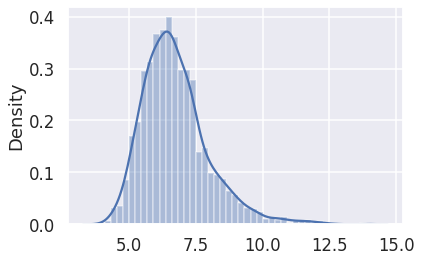

In [72]:
x = dist.Exponential().sample(key=rng_key, sample_shape=(2000, 500))
xmax = x.max(axis=1)
sns.distplot(xmax)
plt.show()

In [73]:

def model(xmax=None, N=0):
    loc = numpyro.sample("loc", dist.Uniform(0,10))
    scale = numpyro.sample('scale', dist.HalfNormal(5))

    with numpyro.plate('N', N):
        numpyro.sample("xmax", dist.Gumbel(loc=loc, scale=scale), obs=xmax)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000, num_chains=4)

rng_key = random.PRNGKey(0)

mcmc.run(rng_key, xmax=xmax, N=len(xmax))
samples = mcmc.get_samples()
idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 6000/6000 [00:00<00:00, 6098.30it/s, 7 steps of size 6.77e-01. acc. prob=0.94]


In [74]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

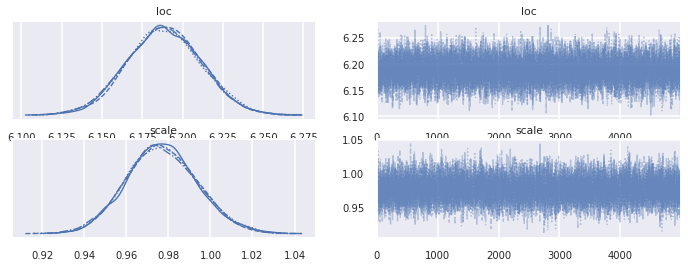

In [75]:
az.plot_trace(idata)
plt.show()

In [76]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc,6.188,0.023,6.145,6.231,0.0,0.0,12736.0,11916.0,1.0
scale,0.977,0.017,0.945,1.009,0.0,0.0,11889.0,12170.0,1.0


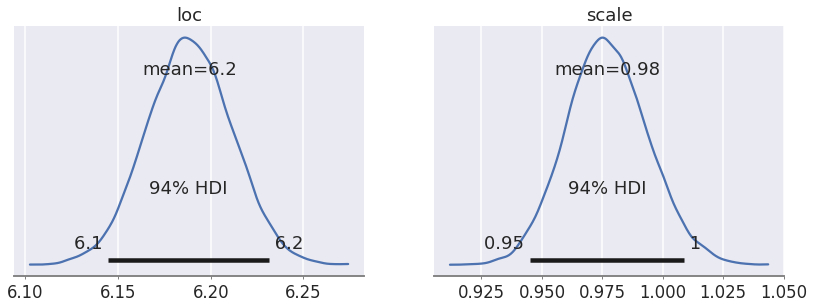

In [77]:
az.plot_posterior(idata)
plt.show()

In [78]:
idata.posterior["loc"]

<xarray.DataArray 'loc' (chain: 4, draw: 5000)>
array([[6.2110906, 6.1897893, 6.2144523, ..., 6.217351 , 6.162114 ,
        6.1546764],
       [6.2179275, 6.2110047, 6.2031794, ..., 6.2323437, 6.1584573,
        6.1585054],
       [6.1927605, 6.2158675, 6.1845512, ..., 6.195529 , 6.1723046,
        6.178893 ],
       [6.172728 , 6.2061596, 6.203498 , ..., 6.1957674, 6.1443567,
        6.1906724]], dtype=float32)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 4993 4994 4995 4996 4997 4998 4999

In [79]:
predictive = Predictive(model, samples)
ppc_samples = predictive(random.PRNGKey(1), N=len(xmax))
idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

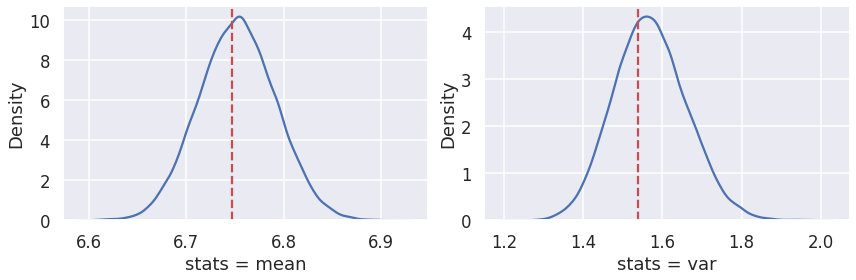

In [80]:
ppc_mean = ppc_samples["xmax"].mean(axis=1)
ppc_var = ppc_samples["xmax"].var(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.kdeplot(ppc_mean, ax=axes[0])
axes[0].axvline(xmax.mean(), color="r", linestyle="dashed")
axes[0].set_xlabel("stats = mean")

sns.kdeplot(ppc_var, ax=axes[1])
axes[1].axvline(xmax.var(), color="r", linestyle="dashed")
axes[1].set_xlabel("stats = var")

plt.tight_layout()
plt.show()

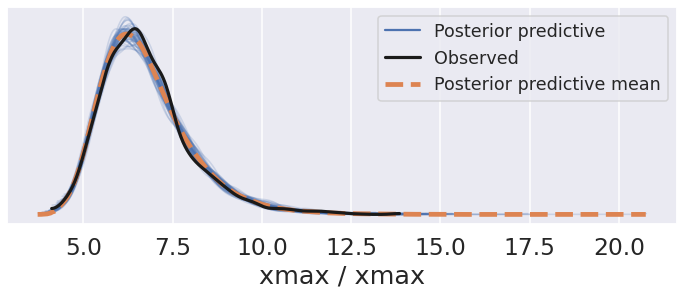

In [81]:
az.plot_ppc(idata_ppc, kind="kde", num_pp_samples=50, figsize=(12,4))
plt.show()

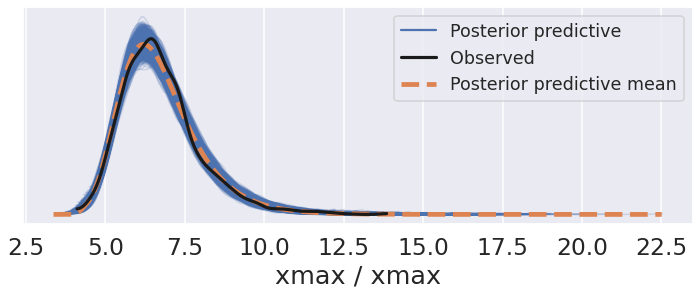

In [82]:
az.plot_ppc(idata_ppc, kind="kde", num_pp_samples=3000, figsize=(12,4))
plt.show()

## 形状母数も含めて推定

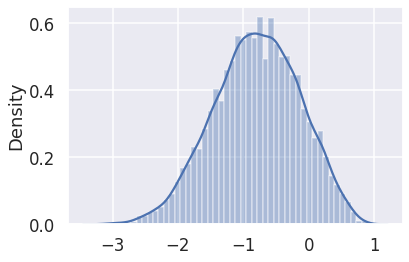

In [83]:
# TransformedDistributionで想像する分布がサンプリングできるか確認
x = dist.TransformedDistribution(
                        dist.Weibull(scale=2, concentration=3), 
                        dist.transforms.AffineTransform(1, -1)
                        ).sample(key=rng_key, sample_shape=(10000,))
sns.distplot(x)
plt.show()

In [84]:
class MyWeibull(dist.Weibull):

    arg_constraints = {
        "scale": dist.constraints.positive,
        "concentration": dist.constraints.real
    }
    reparametrized_params = ["scale", "concentration"]
    def __init__(self, scale=1.0, concentration=1.0, validate_args=True):
        super().__init__(scale, concentration, validate_args=validate_args)

class MyAffineTransform(dist.transforms.Transform):

    def __init__(self, loc, scale, domain=constraints.real):
        self.loc = loc
        self.scale = scale
        self.domain = domain

    @property
    def codomain(self):
        if self.domain is constraints.real:
            return constraints.real
        elif isinstance(self.domain, constraints.greater_than):
            return constraints.less_than(self(self.domain.lower_bound))
        elif isinstance(self.domain, constraints.less_than):
            return constraints.greater_than(self(self.domain.upper_bound))
        elif isinstance(self.domain, constraints.interval):
            return constraints.interval(
                    self(self.domain.upper_bound), self(self.domain.lower_bound)
            )
        else:
            raise NotImplementedError

    def __call__(self, x):
        return self.loc + self.scale * x

    def _inverse(self, y):
        return (y - self.loc) / self.scale

    def log_abs_det_jacobian(self, x, y, intermediates=None):
        return jnp.broadcast_to(jnp.log(jnp.abs(self.scale)), jnp.shape(x))


    def forward_shape(self, shape):
        return lax.broadcast_shapes(
            shape, getattr(self.loc, "shape", ()), getattr(self.scale, "shape", ())
        )

    def inverse_shape(self, shape):
        return lax.broadcast_shapes(
            shape, getattr(self.loc, "shape", ()), getattr(self.scale, "shape", ())
        )

sample: 100%|██████████| 4000/4000 [00:07<00:00, 543.58it/s, 7 steps of size 4.90e-02. acc. prob=0.93]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       loc      4.09      0.01      4.09      4.07      4.10    336.48      1.00
     scale      3.01      0.04      3.01      2.95      3.06   1297.83      1.00
     shape      2.25      0.04      2.25      2.19      2.31   1610.09      1.00

Number of divergences: 22


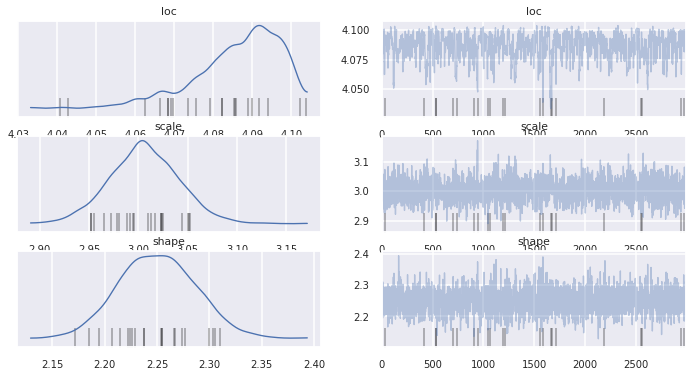

In [88]:
def model(x=None, N=0):
    loc = numpyro.sample("loc", dist.Uniform(low=-5,high=5))
    scale = numpyro.sample('scale', dist.HalfNormal(scale=5))
    xi = numpyro.sample('shape', dist.Normal(loc=0,scale=1))
    sign = jnp.sign(-xi)
    with numpyro.plate('N', N):
        x = numpyro.sample(
            "obs", 
            dist.TransformedDistribution(
                MyWeibull(scale=scale, concentration=xi), 
                MyAffineTransform(loc=loc, scale=1)
                ),
            obs=x
            )
    return x

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=3000, num_chains=1)

rng_key = random.PRNGKey(0)

mcmc.run(rng_key, x=xmax, N=len(xmax))
samples = mcmc.get_samples()
mcmc.print_summary()

az.plot_trace(mcmc)
plt.show()

In [89]:
predictive = Predictive(model, samples)
ppc_samples = predictive(random.PRNGKey(1), N=len(xmax))
idata_ppc = az.from_numpyro(mcmc, posterior_predictive=ppc_samples)

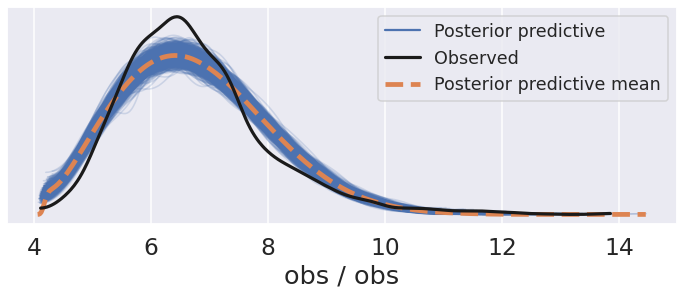

In [91]:
az.plot_ppc(idata_ppc, kind="kde", num_pp_samples=1000, figsize=(12,4))
plt.show()

観測値をうまく説明できない部分が見える。実際Gumbel分布が正解となるのでこれはそう。Gumbelも含めて一気にまるっと推定できないだろうか。